In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns
import os

from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from statsmodels.stats.multitest import fdrcorrection, multipletests
from tqdm import tqdm

# Defining paths to data and results
DATA_ROOT_FOLDER = os.path.join(os.pardir, "data")
DATA_PATH = os.path.join(DATA_ROOT_FOLDER, "ov_tcga")
RESULTS_PATH = os.path.join(os.pardir, "results", "ov_cancer")

%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

# Download the dataset
Ovarian Serous Cystadenocarcinoma (TCGA, Firehose Legacy)

In [106]:
import wget

url = "http://download.cbioportal.org/ov_tcga.tar.gz"
wget.download(url, DATA_PATH)

<IPython.core.display.Javascript object>

In [108]:
import subprocess

command = ["tar", "chvfz", DATA_PATH, "*"]
subprocess.run(command)

CompletedProcess(args=['tar', 'chvfz', '../data/ov_tcga', '*'], returncode=1)

<IPython.core.display.Javascript object>

# Load and preprocess survival data

In [27]:
path_to_clinical_data = os.path.join(DATA_PATH, "data_bcr_clinical_data_patient.txt")
df_survival = pd.read_csv(path_to_clinical_data, sep="\t", index_col=0)
df_survival.rename(
    index=str,
    columns={
        "Overall Survival Status": "OSS",
        "Overall Survival (Months)": "OSM",
        "Patient Identifier": "ID",
    },
    inplace=True,
)

<IPython.core.display.Javascript object>

In [28]:
df_survival.head()

,ID,Form completion date,Tissue Prospective Collection Indicator,Tissue Retrospective Collection Indicator,Sex,Race Category,Ethnicity Category,Patient Jewish Heritage Text Category,Prior Cancer Diagnosis Occurence,Neoadjuvant Therapy Type Administered Prior To Resection Text,...,American Joint Committee on Cancer Tumor Stage Code,Neoplasm Disease Stage American Joint Committee on Cancer Code,Project code,Stage Other,American Joint Committee on Cancer Publication Version Type,Tissue Source Site,OSS,OSM,Disease Free Status,Disease Free (Months)
#Other Patient ID,,,,,,,,,,,,,,,,,,,,,
#Legacy DMP patient identifier (DMPnnnn),Identifier to uniquely specify a patient.,Form completion date,Text indicator for the time frame of tissue pr...,Text indicator for the time frame of tissue pr...,Sex,The text for reporting information about race.,The text for reporting information about ethni...,Text names for Jewish heritage categories for ...,Text term to describe the patient's history of...,Text term to describe the patient's history of...,...,Code of pathological T (primary tumor) to defi...,"The extent of a cancer, especially whether the...",Project code,Stage Other,The version or edition of the American Joint C...,"A Tissue Source Site collects samples (tissue,...",Overall patient survival status.,Overall survival in months since initial diago...,Disease free status since initial treatment.,Disease free (months) since initial treatment.
#STRING,STRING,STRING,STRING,STRING,STRING,STRING,STRING,STRING,STRING,STRING,...,STRING,STRING,STRING,STRING,STRING,STRING,STRING,NUMBER,STRING,NUMBER
#1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
OTHER_PATIENT_ID,PATIENT_ID,FORM_COMPLETION_DATE,PROSPECTIVE_COLLECTION,RETROSPECTIVE_COLLECTION,SEX,RACE,ETHNICITY,JEWISH_RELIGION_HERITAGE_INDICATOR,HISTORY_OTHER_MALIGNANCY,HISTORY_NEOADJUVANT_TRTYN,...,PATH_T_STAGE,AJCC_PATHOLOGIC_TUMOR_STAGE,PROJECT_CODE,STAGE_OTHER,AJCC_STAGING_EDITION,TISSUE_SOURCE_SITE,OS_STATUS,OS_MONTHS,DFS_STATUS,DFS_MONTHS
6d10d4ee-6331-4bba-93bc-a7b64cc0b22a,TCGA-04-1331,3/26/09,[Not Available],[Not Available],Female,WHITE,NOT HISPANIC OR LATINO,[Not Available],[Not Available],No,...,[Not Applicable],[Not Applicable],[Not Available],[Not Available],[Not Available],4,DECEASED,43.89,Recurred/Progressed,15.08


<IPython.core.display.Javascript object>

In [30]:
df_survival = df_survival[4:]

<IPython.core.display.Javascript object>

In [31]:
df_survival.head()

,ID,Form completion date,Tissue Prospective Collection Indicator,Tissue Retrospective Collection Indicator,Sex,Race Category,Ethnicity Category,Patient Jewish Heritage Text Category,Prior Cancer Diagnosis Occurence,Neoadjuvant Therapy Type Administered Prior To Resection Text,...,American Joint Committee on Cancer Tumor Stage Code,Neoplasm Disease Stage American Joint Committee on Cancer Code,Project code,Stage Other,American Joint Committee on Cancer Publication Version Type,Tissue Source Site,OSS,OSM,Disease Free Status,Disease Free (Months)
#Other Patient ID,,,,,,,,,,,,,,,,,,,,,
6d10d4ee-6331-4bba-93bc-a7b64cc0b22a,TCGA-04-1331,3/26/09,[Not Available],[Not Available],Female,WHITE,NOT HISPANIC OR LATINO,[Not Available],[Not Available],No,...,[Not Applicable],[Not Applicable],[Not Available],[Not Available],[Not Available],4,DECEASED,43.89,Recurred/Progressed,15.08
b46263ab-c3ca-4fda-a895-74c7e6e6fe22,TCGA-04-1332,3/26/09,[Not Available],[Not Available],Female,WHITE,NOT HISPANIC OR LATINO,[Not Available],[Not Available],No,...,[Not Applicable],[Not Applicable],[Not Available],[Not Available],[Not Available],4,DECEASED,40.97,Recurred/Progressed,12.91
ab3dbbbe-eed6-4a35-a505-1815225e86c9,TCGA-04-1335,3/26/09,[Not Available],[Not Available],Female,BLACK OR AFRICAN AMERICAN,NOT HISPANIC OR LATINO,[Not Available],[Not Available],No,...,[Not Applicable],[Not Applicable],[Not Available],[Not Available],[Not Available],4,DECEASED,1.81,[Not Available],[Not Available]
538acb2a-c4ca-4656-a91c-841a42dbf15f,TCGA-04-1336,5/11/09,[Not Available],[Not Available],Female,WHITE,[Not Available],[Not Available],[Not Available],No,...,[Not Applicable],[Not Applicable],[Not Available],[Not Available],[Not Available],4,LIVING,49.11,DiseaseFree,49.11
d1e974e7-dd68-40cc-ad06-2b57d964e5a1,TCGA-04-1337,3/26/09,[Not Available],[Not Available],Female,WHITE,NOT HISPANIC OR LATINO,[Not Available],[Not Available],No,...,[Not Applicable],[Not Applicable],[Not Available],[Not Available],[Not Available],4,DECEASED,2,[Not Available],[Not Available]


<IPython.core.display.Javascript object>

In [32]:
df_survival = df_survival[["ID", "OSM", "OSS"]]

<IPython.core.display.Javascript object>

In [33]:
df_survival.head()

,ID,OSM,OSS
#Other Patient ID,,,
6d10d4ee-6331-4bba-93bc-a7b64cc0b22a,TCGA-04-1331,43.89,DECEASED
b46263ab-c3ca-4fda-a895-74c7e6e6fe22,TCGA-04-1332,40.97,DECEASED
ab3dbbbe-eed6-4a35-a505-1815225e86c9,TCGA-04-1335,1.81,DECEASED
538acb2a-c4ca-4656-a91c-841a42dbf15f,TCGA-04-1336,49.11,LIVING
d1e974e7-dd68-40cc-ad06-2b57d964e5a1,TCGA-04-1337,2,DECEASED


<IPython.core.display.Javascript object>

In [34]:
df_survival = df_survival.set_index("ID")

<IPython.core.display.Javascript object>

In [35]:
mask1 = df_survival.OSS == "DECEASED"
mask2 = df_survival.OSS == "LIVING"

df_survival.loc[mask1, "OSS"] = 1
df_survival.loc[mask2, "OSS"] = 0

df_survival = df_survival[df_survival["OSM"] != "[Not Available]"]
df_survival[["OSM"]] = df_survival[["OSM"]].apply(pd.to_numeric)

/Users/Piotr/Documents/Aneczka_job/ssc_analysis/hnsc_analysis/hnsc_env/lib/python3.6/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


<IPython.core.display.Javascript object>

In [36]:
df_survival.head()

,OSM,OSS
ID,,
TCGA-04-1331,43.89,1
TCGA-04-1332,40.97,1
TCGA-04-1335,1.81,1
TCGA-04-1336,49.11,0
TCGA-04-1337,2.00,1


<IPython.core.display.Javascript object>

# Load and preprocess mutation data

In [49]:
path_to_mutation_data = os.path.join(DATA_PATH, "data_linear_CNA.txt")
df_mutation = pd.read_csv(path_to_mutation_data, sep="\t", index_col=0)
df_mutation = df_mutation.T

<IPython.core.display.Javascript object>

In [50]:
df_mutation.head()

Hugo_Symbol,ACAP3,ACTRT2,AGRN,ANKRD65,ATAD3A,ATAD3B,ATAD3C,AURKAIP1,B3GALT6,C1orf159,...,SMIM9,SNORA36A,SNORA56,TMLHE,VBP1,IL9R|ENSG00000124334.12,SPRY3|ENSG00000168939.6,VAMP7|ENSG00000124333.10,WASH6P|ENSG00000182484.10,WASIR1|ENSG00000185203.7
Entrez_Gene_Id,116983.000,140625.000,375790.000,441869.000,55210.000,83858.000,219293.000,54998.000,126792.000,54991.000,...,1.001330e+08,677817.000,677835.000,55217.000,7411.000,NaN,NaN,NaN,NaN,NaN
TCGA-04-1331-01,-0.703,-0.703,-0.703,-0.703,-0.703,-0.703,-0.703,-0.703,-0.703,-0.703,...,-3.680000e-01,-0.368,-0.368,-0.368,-0.368,-0.368,-0.368,-0.368,-0.368,-0.368
TCGA-04-1332-01,0.080,0.080,0.080,0.080,0.080,0.080,0.080,0.080,0.080,0.080,...,-2.560000e-01,-0.256,-0.256,-0.256,-0.256,-0.256,-0.256,-0.256,-0.256,-0.256
TCGA-04-1335-01,-0.807,-0.807,-0.807,-0.807,-0.807,-0.807,-0.807,-0.807,-0.807,-0.807,...,6.730000e-01,0.673,0.673,0.673,0.673,0.673,0.673,0.673,0.673,0.673
TCGA-04-1336-01,0.101,0.101,0.101,0.101,0.101,0.101,0.101,0.101,0.101,0.101,...,-3.360000e-01,-0.336,-0.336,-0.336,-0.336,-0.336,-0.336,-0.336,-0.336,-0.336


<IPython.core.display.Javascript object>

### Choose genes of interest

In [51]:
df_mutation = df_mutation[1:]
genes = ["MYC", "HSF1", "HSF2"]
df_mutation = df_mutation[genes]

<IPython.core.display.Javascript object>

In [52]:
df_mutation.head()

Hugo_Symbol,MYC,HSF1,HSF2
TCGA-04-1331-01,0.040,0.040,-0.805
TCGA-04-1332-01,0.370,0.370,-0.384
TCGA-04-1335-01,0.751,0.748,-0.804
TCGA-04-1336-01,1.471,1.471,0.000
TCGA-04-1337-01,-0.011,-0.039,-0.430


<IPython.core.display.Javascript object>

### Rename indices so that the dataframes can be merged

In [56]:
df_mutation = df_mutation.rename(index=lambda x: x[:-3])

<IPython.core.display.Javascript object>

In [59]:
df_mutation.head()

Hugo_Symbol,MYC,HSF1,HSF2
TCGA-04-1331,0.040,0.040,-0.805
TCGA-04-1332,0.370,0.370,-0.384
TCGA-04-1335,0.751,0.748,-0.804
TCGA-04-1336,1.471,1.471,0.000
TCGA-04-1337,-0.011,-0.039,-0.430


<IPython.core.display.Javascript object>

# Merging dataframes

In [61]:
df = pd.concat([df_survival, df_mutation], axis=1)

<IPython.core.display.Javascript object>

In [62]:
df.head()

,OSM,OSS,MYC,HSF1,HSF2
TCGA-04-1331,43.89,1,0.040,0.040,-0.805
TCGA-04-1332,40.97,1,0.370,0.370,-0.384
TCGA-04-1335,1.81,1,0.751,0.748,-0.804
TCGA-04-1336,49.11,0,1.471,1.471,0.000
TCGA-04-1337,2.00,1,-0.011,-0.039,-0.430


<IPython.core.display.Javascript object>

In [68]:
df.shape

(597, 5)

<IPython.core.display.Javascript object>

In [75]:
df.dropna(inplace=True)

<IPython.core.display.Javascript object>

In [77]:
df.describe()

,OSM,MYC,HSF1,HSF2
count,564.000000,564.000000,564.000000,564.000000
mean,38.954947,1.099436,0.875371,-0.260323
std,30.785847,1.038473,0.963988,0.492938
min,0.260000,-0.664000,-1.260000,-1.293000
25%,15.322500,0.217250,0.101000,-0.651750
50%,33.030000,0.896500,0.746500,-0.294000
75%,55.222500,1.649750,1.456000,0.010000
max,180.060000,3.657000,3.657000,1.571000


<IPython.core.display.Javascript object>

In [80]:
df.shape

(564, 5)

<IPython.core.display.Javascript object>

# Creating Kaplan-Meier curves

In [100]:
plt.rcParams.update({"font.size": 16})


def kaplan_meier(T, E, mask1, mask2, label1, label2, savedir=None, plt_show=True):
    """ returns p-value coming from the logrank test"""
    results = logrank_test(
        T[mask1], T[mask2], event_observed_A=E[mask1], event_observed_B=E[mask2]
    )

    kmf = KaplanMeierFitter()

    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111)

    kmf.fit(T[mask1], event_observed=E[mask1], label=label1)
    ax = kmf.plot(ax=ax, ci_show=False)

    kmf.fit(T[mask2], event_observed=E[mask2], label=label2)
    ax = kmf.plot(ax=ax, ci_show=False)

    plt.suptitle(f"LogRank test p-value: {results.p_value}")

    plt.title("Kaplan-Meier analysis of survival functions")
    plt.xlabel("Overal survival in months")
    plt.ylabel("Cumulative survival")

    if savedir != None:
        plt.savefig(savedir)

    if plt_show:
        plt.show()

    return results.p_value

<IPython.core.display.Javascript object>

/Users/Piotr/Documents/Aneczka_job/ssc_analysis/hnsc_analysis/hnsc_env/lib/python3.6/site-packages/lifelines/utils/__init__.py:1172: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/Users/Piotr/Documents/Aneczka_job/ssc_analysis/hnsc_analysis/hnsc_env/lib/python3.6/site-packages/lifelines/utils/__init__.py:1172: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


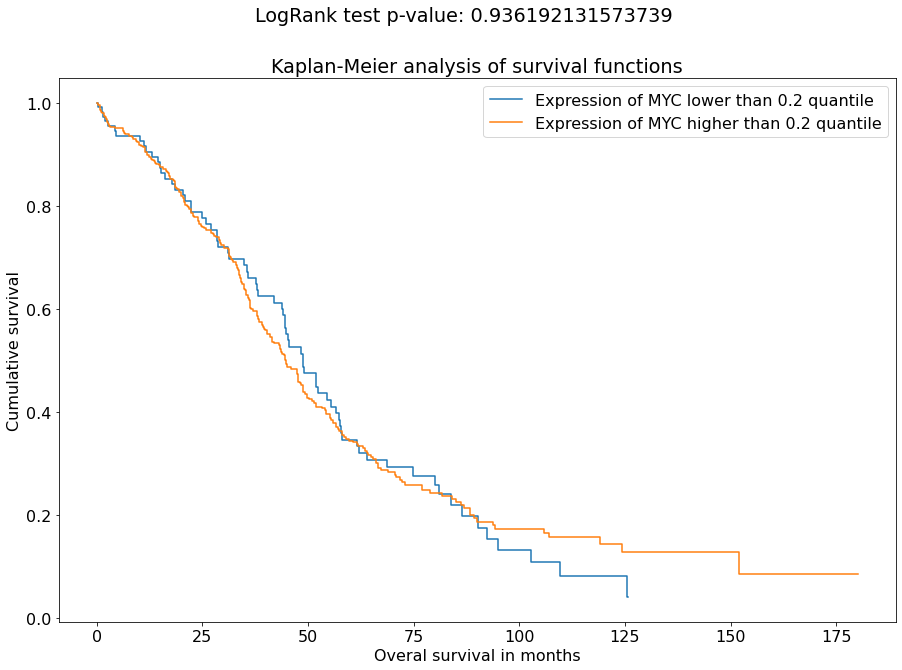

P-value for MYC with threshold set to 0.2 quantile: 0.936192131573739



/Users/Piotr/Documents/Aneczka_job/ssc_analysis/hnsc_analysis/hnsc_env/lib/python3.6/site-packages/lifelines/utils/__init__.py:1172: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/Users/Piotr/Documents/Aneczka_job/ssc_analysis/hnsc_analysis/hnsc_env/lib/python3.6/site-packages/lifelines/utils/__init__.py:1172: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


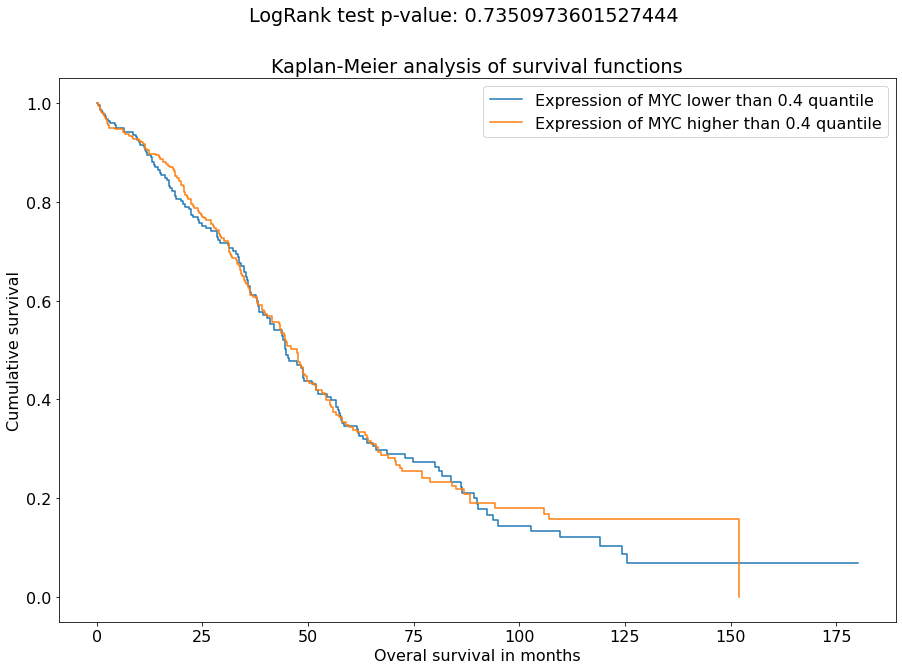

P-value for MYC with threshold set to 0.4 quantile: 0.7350973601527444



/Users/Piotr/Documents/Aneczka_job/ssc_analysis/hnsc_analysis/hnsc_env/lib/python3.6/site-packages/lifelines/utils/__init__.py:1172: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/Users/Piotr/Documents/Aneczka_job/ssc_analysis/hnsc_analysis/hnsc_env/lib/python3.6/site-packages/lifelines/utils/__init__.py:1172: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


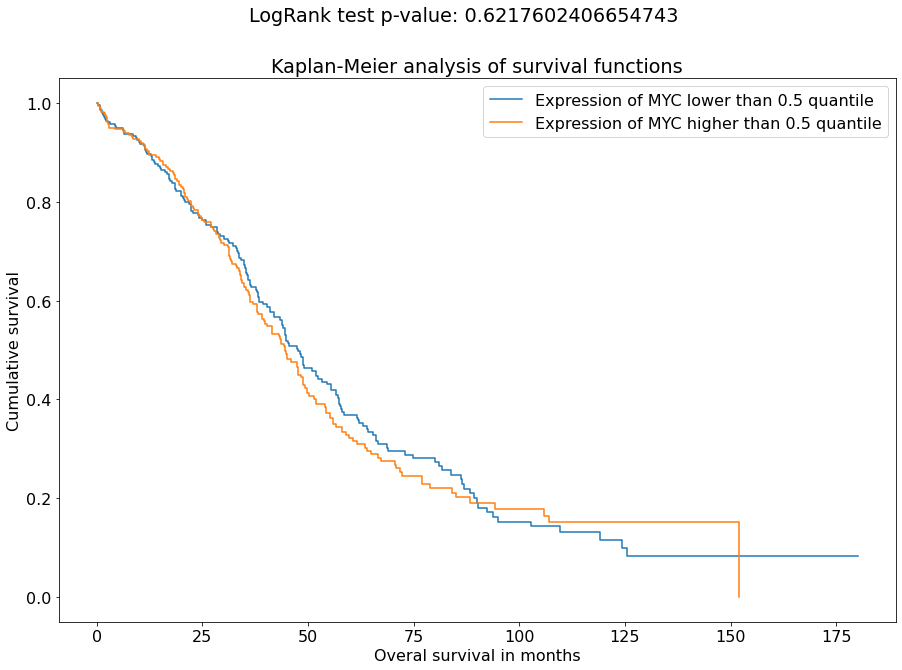

P-value for MYC with threshold set to 0.5 quantile: 0.6217602406654743



/Users/Piotr/Documents/Aneczka_job/ssc_analysis/hnsc_analysis/hnsc_env/lib/python3.6/site-packages/lifelines/utils/__init__.py:1172: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/Users/Piotr/Documents/Aneczka_job/ssc_analysis/hnsc_analysis/hnsc_env/lib/python3.6/site-packages/lifelines/utils/__init__.py:1172: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


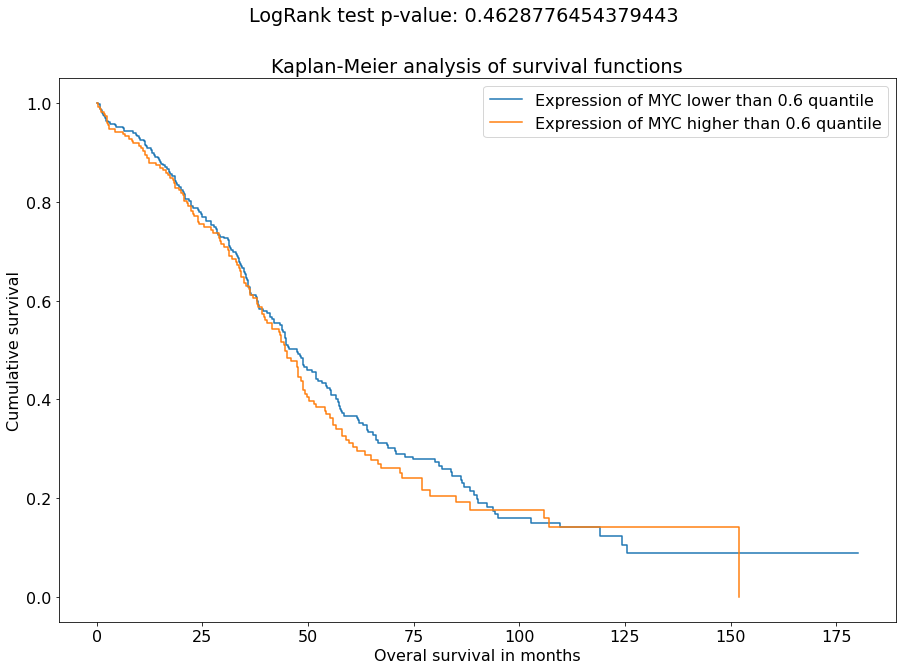

P-value for MYC with threshold set to 0.6 quantile: 0.4628776454379443



/Users/Piotr/Documents/Aneczka_job/ssc_analysis/hnsc_analysis/hnsc_env/lib/python3.6/site-packages/lifelines/utils/__init__.py:1172: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/Users/Piotr/Documents/Aneczka_job/ssc_analysis/hnsc_analysis/hnsc_env/lib/python3.6/site-packages/lifelines/utils/__init__.py:1172: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


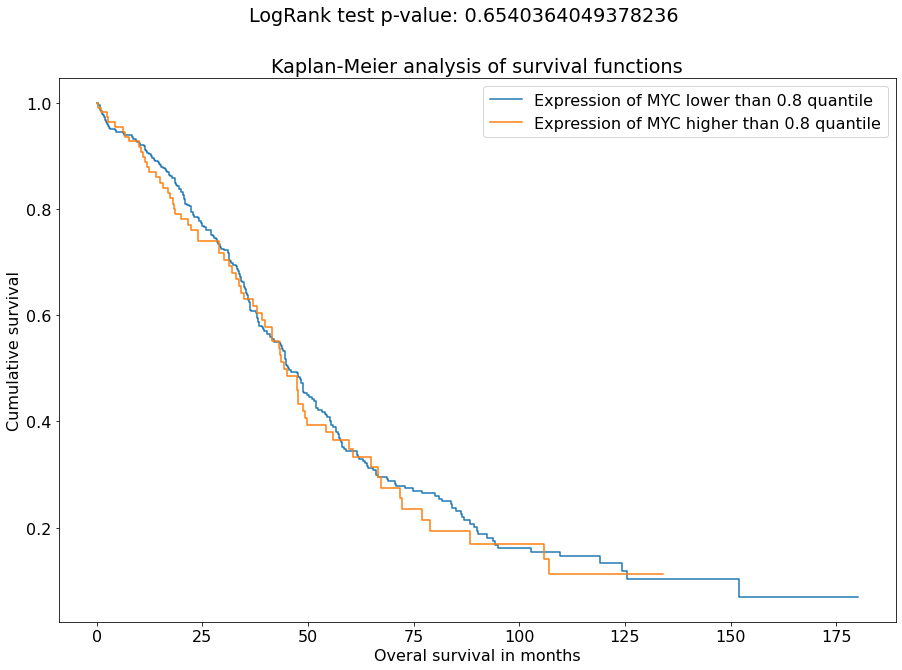

P-value for MYC with threshold set to 0.8 quantile: 0.6540364049378236



/Users/Piotr/Documents/Aneczka_job/ssc_analysis/hnsc_analysis/hnsc_env/lib/python3.6/site-packages/lifelines/utils/__init__.py:1172: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/Users/Piotr/Documents/Aneczka_job/ssc_analysis/hnsc_analysis/hnsc_env/lib/python3.6/site-packages/lifelines/utils/__init__.py:1172: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


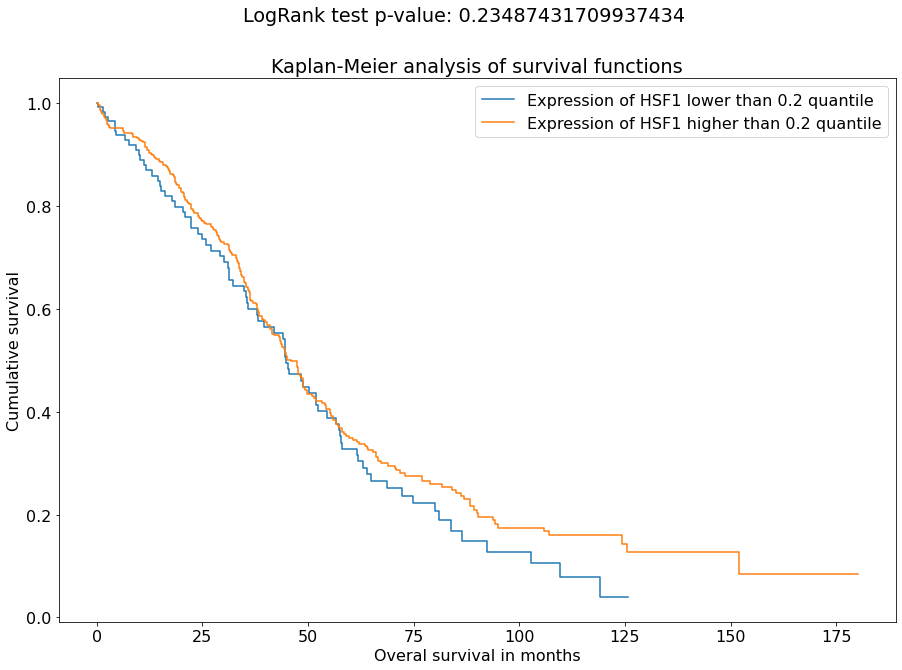

P-value for HSF1 with threshold set to 0.2 quantile: 0.23487431709937434



/Users/Piotr/Documents/Aneczka_job/ssc_analysis/hnsc_analysis/hnsc_env/lib/python3.6/site-packages/lifelines/utils/__init__.py:1172: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/Users/Piotr/Documents/Aneczka_job/ssc_analysis/hnsc_analysis/hnsc_env/lib/python3.6/site-packages/lifelines/utils/__init__.py:1172: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


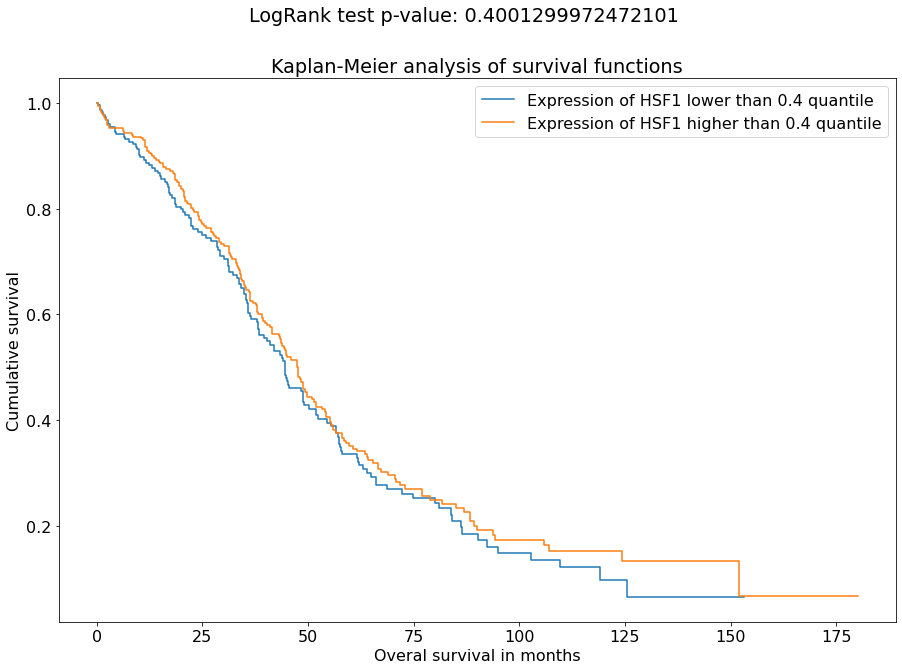

P-value for HSF1 with threshold set to 0.4 quantile: 0.4001299972472101



/Users/Piotr/Documents/Aneczka_job/ssc_analysis/hnsc_analysis/hnsc_env/lib/python3.6/site-packages/lifelines/utils/__init__.py:1172: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/Users/Piotr/Documents/Aneczka_job/ssc_analysis/hnsc_analysis/hnsc_env/lib/python3.6/site-packages/lifelines/utils/__init__.py:1172: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


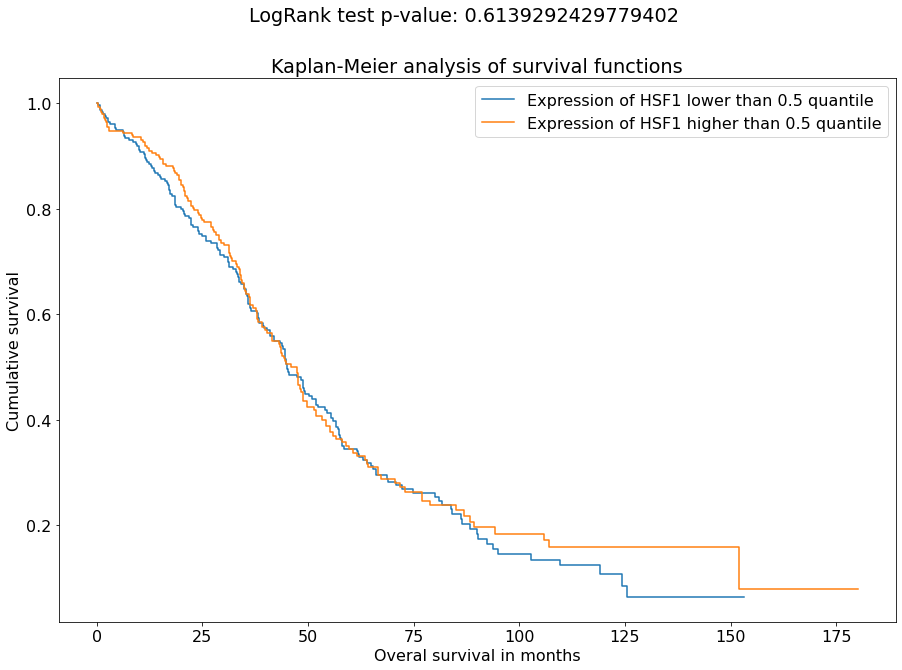

P-value for HSF1 with threshold set to 0.5 quantile: 0.6139292429779402



/Users/Piotr/Documents/Aneczka_job/ssc_analysis/hnsc_analysis/hnsc_env/lib/python3.6/site-packages/lifelines/utils/__init__.py:1172: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/Users/Piotr/Documents/Aneczka_job/ssc_analysis/hnsc_analysis/hnsc_env/lib/python3.6/site-packages/lifelines/utils/__init__.py:1172: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


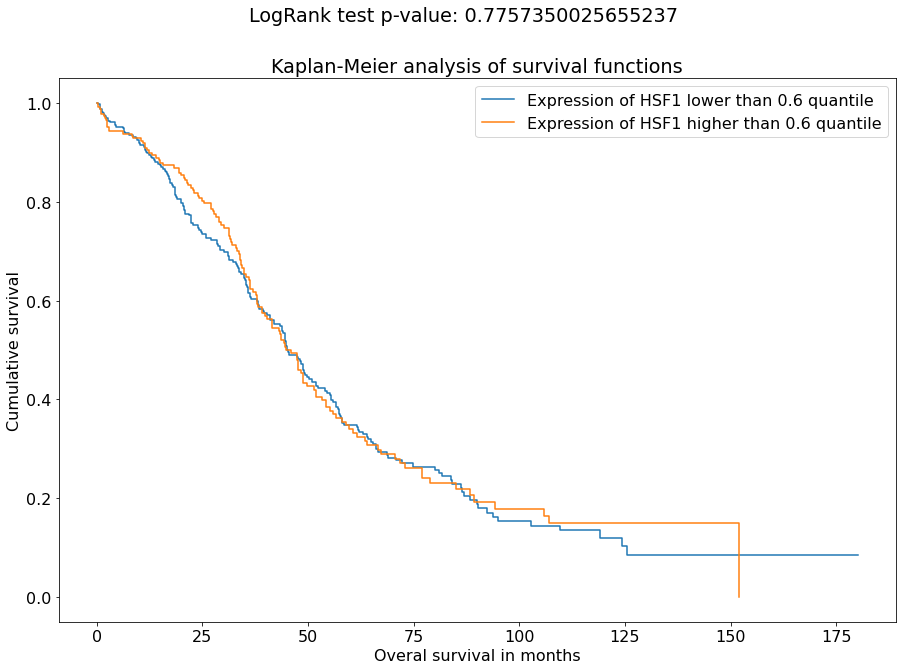

P-value for HSF1 with threshold set to 0.6 quantile: 0.7757350025655237



/Users/Piotr/Documents/Aneczka_job/ssc_analysis/hnsc_analysis/hnsc_env/lib/python3.6/site-packages/lifelines/utils/__init__.py:1172: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/Users/Piotr/Documents/Aneczka_job/ssc_analysis/hnsc_analysis/hnsc_env/lib/python3.6/site-packages/lifelines/utils/__init__.py:1172: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


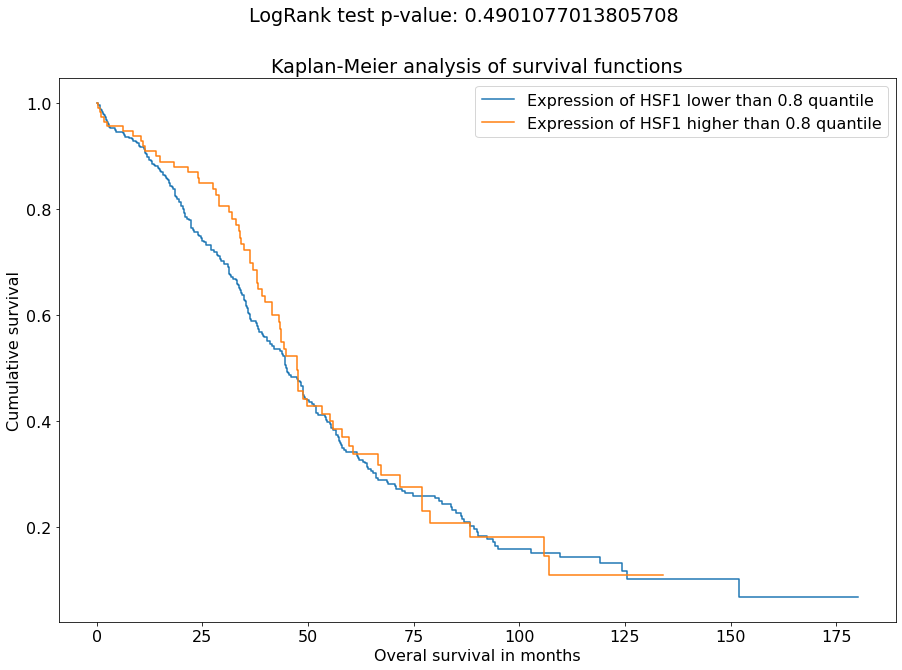

P-value for HSF1 with threshold set to 0.8 quantile: 0.4901077013805708



/Users/Piotr/Documents/Aneczka_job/ssc_analysis/hnsc_analysis/hnsc_env/lib/python3.6/site-packages/lifelines/utils/__init__.py:1172: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/Users/Piotr/Documents/Aneczka_job/ssc_analysis/hnsc_analysis/hnsc_env/lib/python3.6/site-packages/lifelines/utils/__init__.py:1172: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


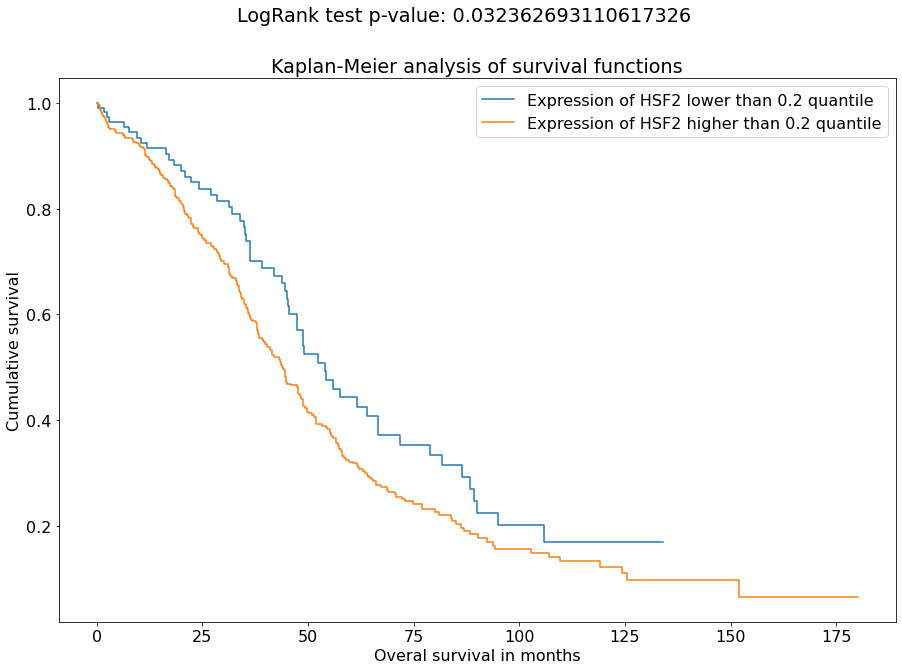

P-value for HSF2 with threshold set to 0.2 quantile: 0.032362693110617326



/Users/Piotr/Documents/Aneczka_job/ssc_analysis/hnsc_analysis/hnsc_env/lib/python3.6/site-packages/lifelines/utils/__init__.py:1172: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/Users/Piotr/Documents/Aneczka_job/ssc_analysis/hnsc_analysis/hnsc_env/lib/python3.6/site-packages/lifelines/utils/__init__.py:1172: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


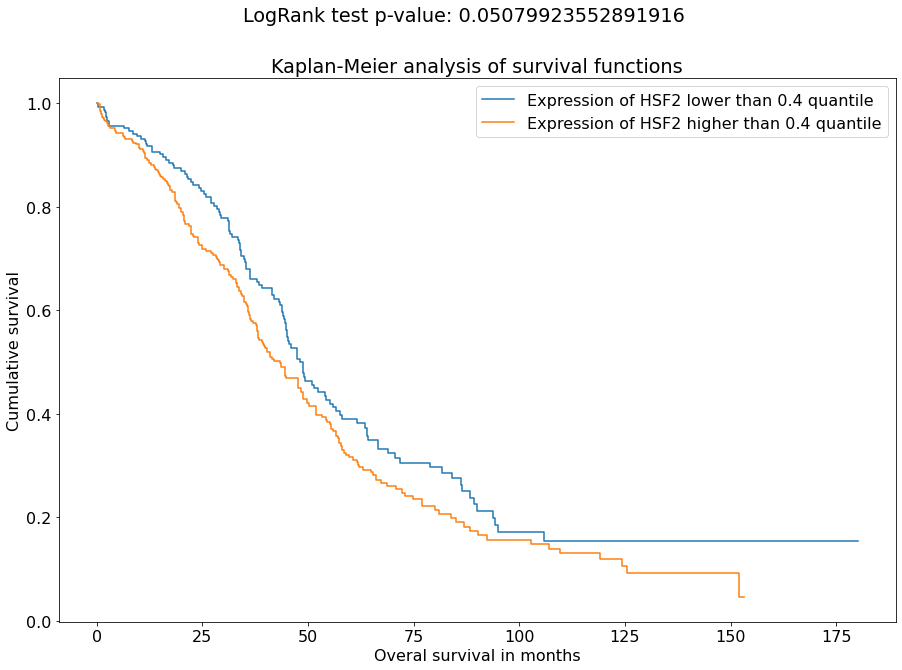

P-value for HSF2 with threshold set to 0.4 quantile: 0.05079923552891916



/Users/Piotr/Documents/Aneczka_job/ssc_analysis/hnsc_analysis/hnsc_env/lib/python3.6/site-packages/lifelines/utils/__init__.py:1172: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/Users/Piotr/Documents/Aneczka_job/ssc_analysis/hnsc_analysis/hnsc_env/lib/python3.6/site-packages/lifelines/utils/__init__.py:1172: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


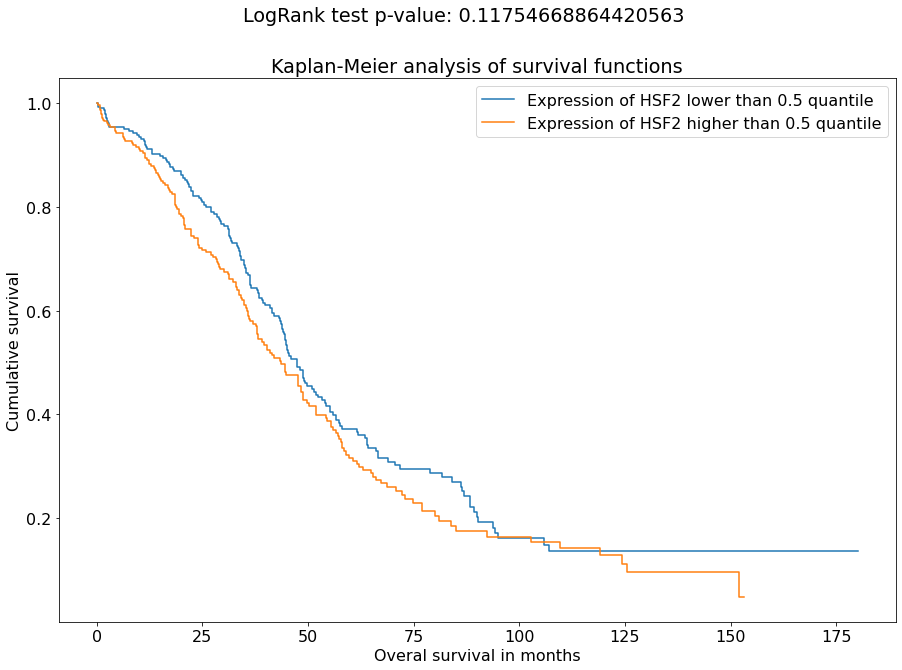

P-value for HSF2 with threshold set to 0.5 quantile: 0.11754668864420563



/Users/Piotr/Documents/Aneczka_job/ssc_analysis/hnsc_analysis/hnsc_env/lib/python3.6/site-packages/lifelines/utils/__init__.py:1172: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/Users/Piotr/Documents/Aneczka_job/ssc_analysis/hnsc_analysis/hnsc_env/lib/python3.6/site-packages/lifelines/utils/__init__.py:1172: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


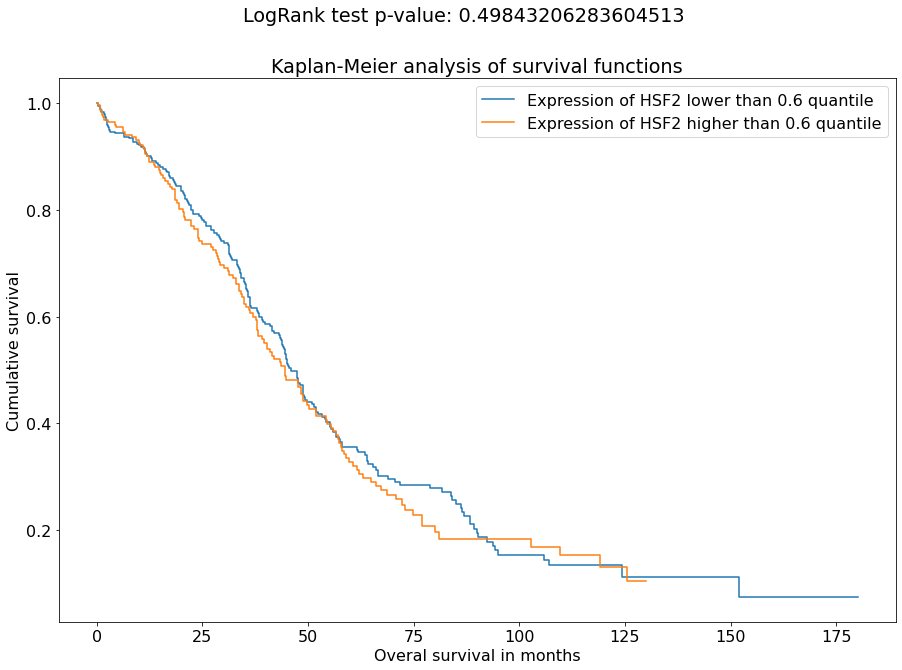

P-value for HSF2 with threshold set to 0.6 quantile: 0.49843206283604513



/Users/Piotr/Documents/Aneczka_job/ssc_analysis/hnsc_analysis/hnsc_env/lib/python3.6/site-packages/lifelines/utils/__init__.py:1172: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/Users/Piotr/Documents/Aneczka_job/ssc_analysis/hnsc_analysis/hnsc_env/lib/python3.6/site-packages/lifelines/utils/__init__.py:1172: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


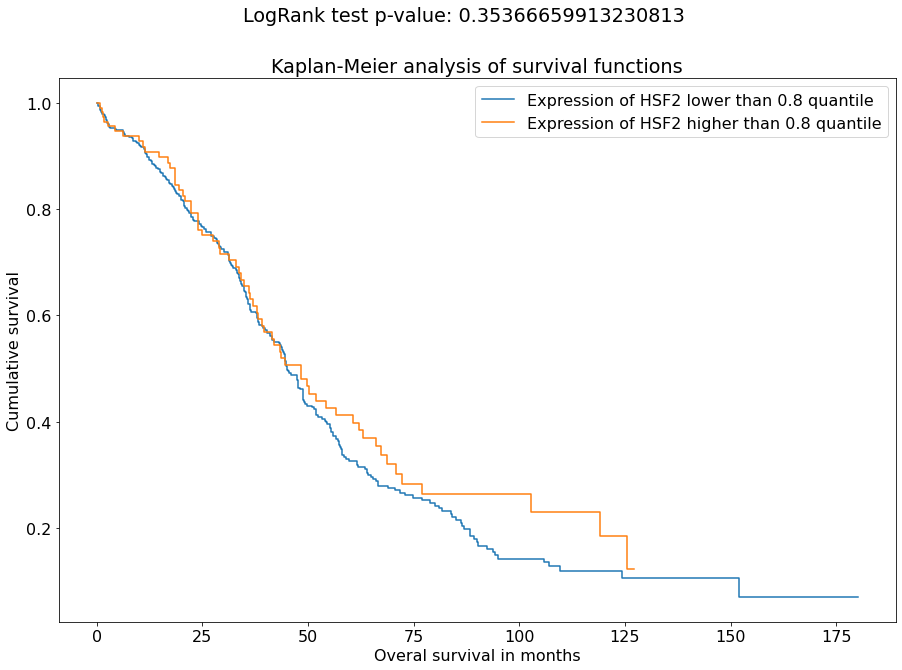

P-value for HSF2 with threshold set to 0.8 quantile: 0.35366659913230813



<IPython.core.display.Javascript object>

In [102]:
T = df["OSM"]
E = df["OSS"]

quantiles = [0.2, 0.4, 0.5, 0.6, 0.8]

for gene in genes:
    for quant in quantiles:

        # Dividing patients between ones with expression close to the average and far from the average
        threshold = df[gene].quantile(quant)
        mask1 = df[gene] < threshold
        mask2 = df[gene] >= threshold

        label1 = f"Expression of {gene} lower than {quant} quantile"
        label2 = f"Expression of {gene} higher than {quant} quantile"

        filename = f"KM_{gene}_{quant}quantile.eps"
        savedir = os.path.join(RESULTS_PATH, filename)

        p = kaplan_meier(
            T=T,
            E=E,
            mask1=mask1,
            mask2=mask2,
            label1=label1,
            label2=label2,
            savedir=savedir,
        )
        print(f"P-value for {gene} with threshold set to {quant} quantile: {p}\n")